In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



\begin{align*}
&\text{Initialization:} \\
&\qquad \text{For each layer } l \in \{1, 2, \ldots, L\}: \\
&\qquad \qquad W^{[l]} \sim \mathcal{N}(0, \sigma^2 I_{n^{[l]}, n^{[l-1]}}) \\
&\qquad \qquad b^{[l]} \sim \mathcal{N}(0, \sigma^2 I_{n^{[l]}}) \\
&\text{Forward Propagation:} \\
&\qquad \text{For each layer } l \in \{1, 2, \ldots, L\}: \\
&\qquad \qquad Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]} \\
&\qquad \qquad A^{[l]} = g^{[l]}(Z^{[l]}) \\
&\text{Cost Calculation:} \\
&\qquad J = -\frac{1}{m} \sum_{i=1}^m \left( y^{(i)} \log(A^{[L] (i)}) + (1 - y^{(i)}) \log(1 - A^{[L] (i)}) \right) \\
&\text{Backpropagation:} \\
&\qquad \text{For each training example } i \in \{1, 2, \ldots, m\}: \\
&\qquad \qquad \text{Output layer:} \\
&\qquad \qquad \qquad dZ^{[L] (i)} = A^{[L] (i)} - y^{(i)} \\
&\qquad \qquad \qquad dW^{[L]} = \frac{1}{m} dZ^{[L] (i)} A^{[L-1] (i) T} \\
&\qquad \qquad \qquad db^{[L]} = \frac{1}{m} \sum_{i=1}^m dZ^{[L] (i)} \\
&\qquad \qquad \qquad dA^{[L-1]} = W^{[L] T} dZ^{[L]} \\
&\qquad \qquad \text{Hidden layers:} \\
&\qquad \qquad \qquad dZ^{[l] (i)} = dA^{[l] (i)} \cdot g^{[l]'}(Z^{[l] (i)}) \\
&\qquad \qquad \qquad dW^{[l]} = \frac{1}{m} dZ^{[l] (i)} A^{[l-1] (i) T} \\
&\qquad \qquad \qquad db^{[l]} = \frac{1}{m} \sum_{i=1}^m dZ^{[l] (i)} \\
&\qquad \qquad \qquad dA^{[l-1]} = W^{[l] T} dZ^{[l]} \\
&\text{Parameter Update:} \\
&\qquad \text{For each layer } l \in \{1, 2, \ldots, L\}: \\
&\qquad \qquad W^{[l]} = W^{[l]} - \alpha dW^{[l]} \\
&\qquad \qquad b^{[l]} = b^{[l]} - \alpha db^{[l]}
\end{align*}




In [2]:
X_train_org, y_train, X_test_org, y_test = np.load('datas/Files/cat_train_x.npy'),np.load('datas/Files/cat_train_y.npy'),np.load('datas/Files/cat_test_x.npy'),np.load('datas/Files/cat_test_y.npy')
train_x_flatten = X_train_org.reshape(X_train_org.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = X_test_org.reshape(X_test_org.shape[0], -1).T

X_train = train_x_flatten/255.
X_test = test_x_flatten/255.

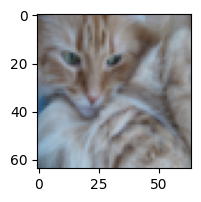

In [3]:
plt.figure(figsize=(2,2))
plt.imshow(X_train_org[2])
plt.show()

In [5]:
class BPNN:
    def __init__(self,layer_dims):
        self.layer_dims = layer_dims
        self.parameters = {}
        self.cost = 0
        self.number_of_layers = len(self.layer_dims) - 1


    def __initialize_paramters(self):
        np.random.seed(1)
        for l in range(1,self.number_of_layers + 1):
            self.parameters["W"+str(l)] = np.random.randn(self.layer_dims[l],self.layer_dims[l-1]) * 0.01
            self.parameters["b"+str(l)] = np.zeros(shape=(self.layer_dims[l],1))
            
    def __forward_propogation(self,X):

        def relu(x):
            return np.maximum(0,x)
        def sigmoid(x):
              return 1 / (1 + np.exp(-x))

        
        def linear_activation_forward(A_prev,W,b,activation):

            if activation == "sigmoid":
                Z = np.dot(W,A_prev) + b
                A = sigmoid(Z)
            elif activation == "relu":
                Z = np.dot(W,A_prev) + b
                A = relu(Z)
            activation_cache = Z
            return A,activation_cache
                
        
        A = X
        caches = []
        L = self.number_of_layers
        
        for l in range(1,self.number_of_layers):
            
            A_prev = A
            W,b = self.parameters["W" + str(l)],self.parameters["b"+str(l)]
            linear_cache = (A_prev,W,b)
            A,activation_cache = linear_activation_forward(A_prev=A_prev,
                                          W=W,
                                          b=b,
                                          activation="relu")
            cache = (linear_cache,activation_cache)
            caches.append(cache)
        
        W,b=self.parameters["W"+ str(L)],self.parameters["b" + str(L)]
        linear_cache = (A,W,b)
        A_last_layer,activation_cache = linear_activation_forward(A_prev=A,
                                                 W=W,
                                                 b=b,
                                                 activation="sigmoid")
        
        cache = (linear_cache,activation_cache)
        caches.append(cache)

        return A_last_layer,caches
            
   
    
    def __backward_propogation(self,A_last_layer,y,caches):

        def linear_activation_backward(dA,cache,activation):
             linear_cache,activation_cache = cache

             if activation == "sigmoid":
                 s = 1 / (1 + np.exp(-activation_cache))
                 dZ = dA * s * (1-s)
             elif activation == "relu":
                 dZ = np.multiply(dA,np.int64(activation_cache > 0))


              # """linear backward"""
             A_prev, W, b = linear_cache
             m = A_prev.shape[1]

             dW = np.dot(dZ,A_prev.T) / m
             db = np.sum(dZ, axis=1, keepdims=True) / m
             dA_prev = np.dot(W.T, dZ)

             return dA_prev, dW, db
              
        
        grads = {}
        L = self.number_of_layers
        y = y.reshape(A_last_layer.shape)

        dA_last_layer = - (np.divide(y, A_last_layer) - np.divide(1 - y, 1 - A_last_layer));
        dA_prev, dW, db = linear_activation_backward(dA_last_layer,caches[L - 1],"sigmoid")        
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db;
        
        for l in reversed(range(L-1)):
            dA = dA_prev
            dA_prev, dW, db = linear_activation_backward(dA,caches[l],"relu")
            grads["dA" + str(l)] = dA_prev
            grads["dW" + str(l + 1)] = dW
            grads["db" + str(l + 1)] = db
            
        grads["dA1"]=grads['dA2']
        del(grads['dA2'])
        
        return grads
    
    def __update_parameters(self,learning_rate,grads):
       
        for l in range(1,self.number_of_layers):
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    def __cost(self,A_last_layer,y):
        m = y.shape[1]
        cost = (-1 / m) * np.sum(np.multiply(y, np.log(A_last_layer)) + np.multiply(1 - y, np.log(1 - A_last_layer)))

        self.cost = np.squeeze(cost)        

    def fit(self,X,y,learning_rate=0.001,num_iter=1000,print_cost=False):

        np.random.seed(1)
        self.__initialize_paramters()

        for i in range(0,num_iter):

            # forward propa=ogation
            last_layer_output,caches = self.__forward_propogation(X)
            
            #calculate cost value
            self.__cost(last_layer_output,y)

            #backward propagation
            grads = self.__backward_propogation(A_last_layer=last_layer_output,
                                                y=y,
                                                caches=caches) 

            #update paramters
            self.__update_parameters(learning_rate=learning_rate,
                                     grads=grads)

            if print_cost and i%100 == 0:
                print("Cost after iteration {}: {}".format(i, np.squeeze(self.cost)))

                
    def predict(self,image):
        A_last_layer, _ = self.__forward_propogation(image)
        print(A_last_layer)
        predictions = (A_last_layer > 0.5).astype(int)  # Assuming binary classification
        
        return predictions

## Model 

In [6]:
layers_dims = [12288,20,7, 5, 1] #  4-layer model

In [ ]:
model = BPNN(layer_dims=layers_dims)
model.fit(
    X=X_train,
    y=y_train,
    learning_rate=0.0075,
    num_iter=2500,
    print_cost=True)

Cost after iteration 0: 0.6931489045172448
Cost after iteration 100: 0.6780101702745841
Cost after iteration 200: 0.6675987910794725
Cost after iteration 300: 0.6604207999632384
Cost after iteration 400: 0.6554567876949472
Cost after iteration 500: 0.652012541899007
Cost after iteration 600: 0.6496150320915259
Cost after iteration 700: 0.6479410865511954
Cost after iteration 800: 0.6467691160823229
Cost after iteration 900: 0.6459465775322725
Cost after iteration 1000: 0.6453680403127725
Cost after iteration 1100: 0.64496035860236
Cost after iteration 1200: 0.6446726082665072
Cost after iteration 1300: 0.6444692242889792
Cost after iteration 1400: 0.6443252989513771
Cost after iteration 1500: 0.6442233455311651
Cost after iteration 1600: 0.6441510610800217
Cost after iteration 1700: 0.6440997737464047
Cost after iteration 1800: 0.6440633613614617
Cost after iteration 1900: 0.6440374958811805
Cost after iteration 2000: 0.6440191140347226
Cost after iteration 2100: 0.6440060455597062
Cos

In [ ]:
model.predict(X_test[:,24].reshape(-1,1))

In [113]:
X_train[:,4].shape

(12288,)

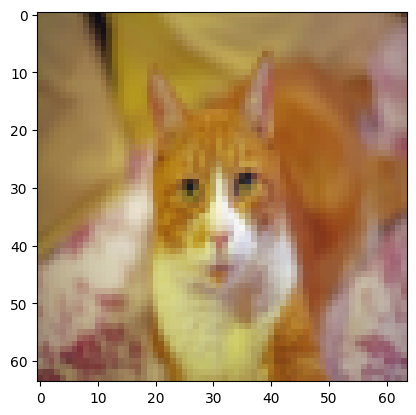

In [116]:
plt.imshow(X_train_org[24])

In [98]:
y_train[:,20:].argmax() + 20

24

In [96]:
y_train[:,20:].shape

(1, 189)

In [131]:
y_test

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

In [108]:
X_test.shape

(12288, 50)

In [189]:
predictions = model.predict(X_train)

[[0.34642667 0.34642955 0.34642755 0.34643018 0.34642315 0.34643274
  0.34643434 0.34642926 0.34643101 0.3464263  0.34643456 0.34643056
  0.34642908 0.34642361 0.34642778 0.34642986 0.34643907 0.34643582
  0.34643024 0.34642894 0.3464298  0.34643101 0.34642956 0.34644164
  0.3464258  0.34642902 0.34642975 0.34642332 0.34642727 0.34643612
  0.34643533 0.34642902 0.34643516 0.34642732 0.34642271 0.3464339
  0.34642606 0.34642778 0.34643163 0.34642672 0.34643334 0.34642747
  0.34643618 0.34643589 0.34642928 0.34643312 0.34642935 0.34642614
  0.34642509 0.34643029 0.34642794 0.34643378 0.34643347 0.34642956
  0.3464329  0.34643544 0.34642811 0.34643789 0.34643143 0.34642824
  0.34642866 0.34643076 0.34643407 0.34643563 0.34642549 0.34643106
  0.34643206 0.34642626 0.34643382 0.34642869 0.34642676 0.34642428
  0.34642997 0.34643363 0.34643147 0.3464282  0.34642692 0.34642846
  0.34643132 0.34643176 0.3464365  0.34643153 0.34643022 0.34643397
  0.34642992 0.34642236 0.34643344 0.34643009 0.3

In [137]:
predictions

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [188]:
model.predict(X_test[:,2].reshape(-1,1))

[[0.34642816]]


array([[0]])

In [126]:
X_test[:,2].reshape(-1,1).shape


(12288, 1)

In [146]:
X_test[:,24].reshape(-1,1)

array([[0.27843137],
       [0.28235294],
       [0.21960784],
       ...,
       [0.24313725],
       [0.15686275],
       [0.09019608]])